In [1]:
from __future__ import print_function 
import numpy as np
import torch
import torch.autograd as ag
import torchvision
import torchvision.transforms as transforms
from matplotlib import pyplot
import MNISTtools 
import torch.nn as nn
import torch.nn.functional as F
from math import exp
import matplotlib as pyplot 

#########################Load and reshape image###############################

def normalize_MNIST_images(x,imgw,imgh,channels,samples):
    x = x.astype(np.float64)
    x = (2*x - np.max(x))/np.max(x)
    x = x.reshape(imgw,imgh,channels,samples)
    x = np.moveaxis(x,[0,1,2,3],[2,3,1,0])  #Samples,input_channels,imgw,imgh
    return x

class generator(nn.Module):

    def __init__(self):
        super(generator, self).__init__()
        #ConvTranspose2d(input_channels,output_channels,kernel_size,stride,padding_value)
        #BatchNorm2d: Applies Batch Normalization over a 4d input that is seen as a mini-batch of 3d inputs
        
        self.deconv1 = nn.ConvTranspose2d(100, 128, 4, 1, 0)
        self.deconv1_bn = nn.BatchNorm2d(128)
        self.deconv2 = nn.ConvTranspose2d(128, 64, 4)
        self.deconv2_bn = nn.BatchNorm2d(64)
        self.deconv3 = nn.ConvTranspose2d(64, 32, 4, 2, 1)
        self.deconv3_bn = nn.BatchNorm2d(32)
        self.deconv4 = nn.ConvTranspose2d(32, 1, 4, 2, 1)

    #Weights initialized from a zero-centered normal distribution with standard deviation 0.02
    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)

    # forward method
    def forward(self, x):
        x = F.relu(self.deconv1_bn(self.deconv1(x)))
        x = F.relu(self.deconv2_bn(self.deconv2(x)))
        x = F.relu(self.deconv3_bn(self.deconv3(x)))
        x = F.tanh(self.deconv4(x))

        return x
    
    
class discriminator(nn.Module):
    # initializers
    def __init__(self):
        super(discriminator, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 4, 2, 1)
        self.conv2 = nn.Conv2d(32, 64, 4, 2, 1)
        self.conv2_bn = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, 4)
        self.conv3_bn = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 1, 4, 1, 0)

    # weight_init
    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)

    # forward method
    def forward(self, input):
        x = F.leaky_relu(self.conv1(input), 0.2)
        x = F.leaky_relu(self.conv2_bn(self.conv2(x)), 0.2)
        x = F.leaky_relu(self.conv3_bn(self.conv3(x)), 0.2)
        x = F.sigmoid(self.conv4(x))

        return x

def normal_init(m, mean, std):
    if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d):
        m.weight.data.normal_(mean, std)
        m.bias.data.zero_()
        


G = generator()
D = discriminator()
G.weight_init(mean=0.0, std=0.02)
D.weight_init(mean=0.0, std=0.02)
if torch.cuda.is_available():
    G.cuda()
    D.cuda()
    print ('USE GPU')

USE GPU


In [2]:
xtrain,ltrain = MNISTtools.load(dataset = "training", path = "/datasets/MNIST")
xtest,ltest = MNISTtools.load(dataset = "testing", path = "/datasets/MNIST")
xtrain = normalize_MNIST_images(xtrain,28,28,1,60000)
xtest = normalize_MNIST_images(xtest,28,28,1,10000)

xtrain = ag.Variable((torch.from_numpy(xtrain).float()).cuda(),requires_grad=True)
ltrain = ag.Variable(torch.from_numpy(ltrain).cuda(),requires_grad=False)
xtest = ag.Variable(torch.from_numpy(xtest).cuda(), requires_grad=False)

    
y_real = torch.ones(100)
y_fake = torch.zeros(100)
y_real = ag.Variable(y_real.cuda())
y_fake = ag.Variable(y_fake.cuda())

In [3]:
N = xtrain.size()[0] # Training set size
B = 100              # Minibacth size
NB = N/B             # Number of minibatches
T = 20               # Number of epochs
gamma = .0001         # Learning rate
rho = .5            # Momentum
    
criterion = nn.BCELoss()
    
G_optimizer = torch.optim.Adam(G.parameters(), lr=gamma, betas=(rho, 0.999))
D_optimizer = torch.optim.Adam(D.parameters(), lr=gamma, betas=(rho, 0.999))
D_losses = []
G_losses = []
    
for epoch in range(T): 
    
    idxminibatches = np.random.permutation(NB) # shuffling 
    for k in range(NB):
        i = idxminibatches[k] # index of minibatch
        
        # Extract i-th minibatch from xtrain and ltrain
        idxsmp = range(i*B,(i+1)*B) # indices of samples for i-th minibatch
            
        inputs = xtrain[idxsmp,:,:,:] 
        
        D.zero_grad()

        D_result = D(inputs).squeeze()              #Real data and losses
        D_real_loss = criterion(D_result, y_real)    #labels is a matrix with ones
            
            
        z_ = torch.randn((100, 100)).view(-1, 100, 1, 1)    
        z_ = ag.Variable(z_.cuda())
        G_result = G(z_)                            #Generated images by G from noises
        
        D_result = D(G_result).squeeze()
        D_fake_loss = criterion(D_result, y_fake)
        D_fake_score = D_result.data.mean()

        D_train_loss = D_real_loss + D_fake_loss

        D_train_loss.backward()
        D_optimizer.step()
            
        D_losses.append(D_train_loss.data[0])
            
        # train generator G
        G.zero_grad()

        z_ = torch.randn((100, 100)).view(-1, 100, 1, 1)
        z_ = ag.Variable(z_.cuda())

        G_result = G(z_)            
        D_result = D(G_result).squeeze()
        G_train_loss = criterion(D_result, y_real)
        G_train_loss.backward()
        G_optimizer.step()

        G_losses.append(G_train_loss.data[0])
            
    print('[%d/%d], loss_d: %.3f, loss_g: %.3f' % ((epoch + 1), T, D_train_loss.data[0],
                                                              G_train_loss.data[0]))
    
torch.save(G.state_dict(), 'netG.pt')
torch.save(D.state_dict(), 'netD.pt')

[1/20], loss_d: 0.006, loss_g: 6.088
[2/20], loss_d: 0.071, loss_g: 4.058
[3/20], loss_d: 1.261, loss_g: 0.004
[4/20], loss_d: 0.242, loss_g: 2.728
[5/20], loss_d: 0.287, loss_g: 3.186
[6/20], loss_d: 0.400, loss_g: 2.121
[7/20], loss_d: 0.669, loss_g: 1.585
[8/20], loss_d: 0.344, loss_g: 2.444
[9/20], loss_d: 1.031, loss_g: 0.887
[10/20], loss_d: 0.610, loss_g: 1.896
[11/20], loss_d: 0.501, loss_g: 2.129
[12/20], loss_d: 0.351, loss_g: 1.478
[13/20], loss_d: 0.332, loss_g: 3.630
[14/20], loss_d: 0.488, loss_g: 2.396
[15/20], loss_d: 0.379, loss_g: 2.923
[16/20], loss_d: 0.406, loss_g: 3.464
[17/20], loss_d: 0.795, loss_g: 1.580
[18/20], loss_d: 0.425, loss_g: 1.520
[19/20], loss_d: 0.482, loss_g: 1.988
[20/20], loss_d: 0.408, loss_g: 1.778


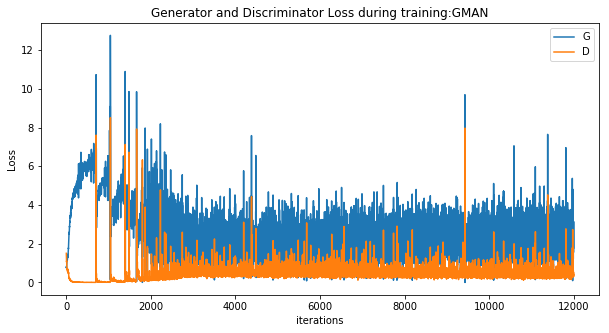

In [4]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.title('Generator and Discriminator Loss during training:GMAN')
plt.plot(G_losses, label='G')
plt.plot(D_losses, label='D')
plt.xlabel('iterations')
plt.ylabel('Loss')
plt.legend()
plt.show()  

In [5]:
z_ = torch.randn((5,100)).view(-1, 100, 1, 1)


z_ = ag.Variable(z_.cuda(), volatile=True)
test_images = G(z_).cpu()
test_images = test_images.data.numpy()
print(type(test_images))
test_images = test_images.squeeze()
print(test_images.shape)
#for i in range(5):
    #MNISTtools.show(test_images[i])

<type 'numpy.ndarray'>
(5, 28, 28)


In [6]:
import torchvision.datasets as dset
def load_dataset(batchSize):
    """Load MNIST or CIFAR-10 dataset."""
    transform = transforms.Compose(
        [transforms.Resize(32),
         transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5),(0.5, 0.5, 0.5))])
    #trainset = dset.CIFAR10(root='./data', train=True, 
    #                      download=True, transform=transform)
    # testset = dset.CIFAR10(root='./data', train=False,
    #                      download=True, transform=transform)
    trainset = dset.MNIST(root='./data', train=True, 
                          download=True, transform=transform)
    testset = dset.MNIST(root='./data', train=False,
                         download=True, transform=transform)
    trainLoader = torch.utils.data.DataLoader(trainset, batch_size=batchSize,
                                              shuffle=True, num_workers=2)
    testLoader = torch.utils.data.DataLoader(testset, batch_size=batchSize,
                                             shuffle=True, num_workers=2)
    return trainLoader, testLoader

trainLoader, testLoader = load_dataset(100)

In [7]:
netG = generator()
netG.load_state_dict(torch.load('netG.pt'))
netG.eval()
netG.cuda()

netD = discriminator()
netD.load_state_dict(torch.load('netD.pt'))
netD.eval()
netD.cuda()

tempD = []
D1 = []




#test all real data on discriminator of GAN
for epoch in range(10):
    for i, (data, target) in enumerate(trainLoader, 0):
        realImg = ag.Variable(data.cuda())
        batchSize = realImg.size(0)
        realLabel = torch.ones(100)
        realLabel = realLabel.cuda()
        output = netD(realImg).view(-1)
        
        D_x = output.mean().data[0]
        tempD.append(D_x)
    av_d = sum(tempD)/len(tempD)
    D1.append(av_d)
    
D1_test = sum(D1)/len(D1)

print(D1_test)

0.747417822379


In [8]:
print(realImg.shape)
print(batchSize)

torch.Size([100, 1, 32, 32])
100
